In [1]:
# Set seed for reproducibility
seed = 123

# Import package/module for data
import numpy as np
import pandas as pd
from seaborn import load_dataset

# Import modules for feature engineering and modelling
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression

In [2]:
# Load dataset
df = load_dataset('tips').drop(columns=['tip', 'sex']).sample(n=5, random_state=seed)

# Add missing values
df.iloc[[1, 2, 4], [2, 4]] = np.nan
df

,total_bill,smoker,day,time,size
112,38.07,No,Sun,Dinner,3.0
19,20.65,No,NaN,Dinner,NaN
187,30.46,Yes,NaN,Dinner,NaN
169,10.63,Yes,Sat,Dinner,2.0
31,18.35,No,NaN,Dinner,NaN


소수의 레코드를 사용하면 각 단계에서 입력 및 출력을 쉽게 모니터링 할 수 있습니다. 따라서 데이터 세트에서 5 개의 레코드 샘플 만 사용합니다.

### 1. 파이프 라인

smoker , day 및 time 열을 사용하여 total_bill 을 예측 한다고 가정 해 보겠습니다 . 먼저 크기 열 을 삭제 하고 데이터를 분할합니다.

In [3]:
# Partition data
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['total_bill', 'size']), 
                                                    df['total_bill'], 
                                                    test_size=.2, 
                                                    random_state=seed)

1. 결측값을 '결측값'으로 대치
2. 원-핫 인코딩

In [4]:
# Impute training data
imputer = SimpleImputer(strategy='constant', fill_value='missing')
X_train_imputed = imputer.fit_transform(X_train)

# Encode training data
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_train_encoded = encoder.fit_transform(X_train_imputed)

# Inspect training data before and after
print("******************** Training data ********************")
display(X_train)
display(pd.DataFrame(X_train_imputed, columns=X_train.columns))
display(pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names(X_train.columns)))

# Transform test data
X_test_imputed = imputer.transform(X_test)
X_test_encoded = encoder.transform(X_test_imputed)

# Inspect test data before and after
print("******************** Test data ********************")
display(X_test)
display(pd.DataFrame(X_test_imputed, columns=X_train.columns))
display(pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names(X_train.columns)))

******************** Training data ********************


,smoker,day,time
169,Yes,Sat,Dinner
31,No,NaN,Dinner
112,No,Sun,Dinner
187,Yes,NaN,Dinner


,smoker,day,time
0,Yes,Sat,Dinner
1,No,missing,Dinner
2,No,Sun,Dinner
3,Yes,missing,Dinner


,smoker_No,smoker_Yes,day_Sat,day_Sun,day_missing,time_Dinner
0,0.0,1.0,1.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,1.0,1.0
2,1.0,0.0,0.0,1.0,0.0,1.0
3,0.0,1.0,0.0,0.0,1.0,1.0


******************** Test data ********************


,smoker,day,time
19,No,NaN,Dinner


,smoker,day,time
0,No,missing,Dinner


,smoker_No,smoker_Yes,day_Sat,day_Sun,day_missing,time_Dinner
0,1.0,0.0,0.0,0.0,1.0,1.0


이전 단계의 출력을 입력으로 다음 단계로 수동으로 공급하고 여러 중간 출력이 있습니다. 또한 테스트 데이터에 대해 각 단계를 반복해야했습니다. 단계 수가 증가할수록 유지 관리가 더 지루해지고 오류가 발생하기 쉽습니다. 다음을 사용하여 더 간결하고 간결한 코드를 작성할 수 있습니다 Pipeline.

In [5]:
# Fit pipeline to training data
pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])
pipe.fit(X_train)

# Inspect training data before and after
print("******************** Training data ********************")
display(X_train)
display(pd.DataFrame(X_train_imputed, columns=X_train.columns))
display(pd.DataFrame(pipe.transform(X_train), columns=pipe['encoder'].get_feature_names(X_train.columns)))

# Inspect test data before and after
print("******************** Test data ********************")
display(X_test)
display(pd.DataFrame(X_test_imputed, columns=X_train.columns))
display(pd.DataFrame(pipe.transform(X_test), columns=pipe['encoder'].get_feature_names(X_train.columns)))


******************** Training data ********************


,smoker,day,time
169,Yes,Sat,Dinner
31,No,NaN,Dinner
112,No,Sun,Dinner
187,Yes,NaN,Dinner


,smoker,day,time
0,Yes,Sat,Dinner
1,No,missing,Dinner
2,No,Sun,Dinner
3,Yes,missing,Dinner


,smoker_No,smoker_Yes,day_Sat,day_Sun,day_missing,time_Dinner
0,0.0,1.0,1.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,1.0,1.0
2,1.0,0.0,0.0,1.0,0.0,1.0
3,0.0,1.0,0.0,0.0,1.0,1.0


******************** Test data ********************


,smoker,day,time
19,No,NaN,Dinner


,smoker,day,time
0,No,missing,Dinner


,smoker_No,smoker_Yes,day_Sat,day_Sun,day_missing,time_Dinner
0,1.0,0.0,0.0,0.0,1.0,1.0


Pipeline각 단계는 출력을 입력으로 다음 단계로 전달합니다. 따라서 데이터의 다른 버전을 수동으로 추적 할 필요가 없습니다. 이 접근 방식은 똑같은 최종 출력을 제공하지만 더 우아한 코드를 제공합니다.

변환 된 데이터를 살펴 보았으므로 이제 예제에 모델을 추가해야합니다. 첫 번째 접근 방식에 간단한 모델을 추가하는 것으로 시작하겠습니다.

In [6]:
# Impute training data
imputer = SimpleImputer(strategy='constant', fill_value='missing')
X_train_imputed = imputer.fit_transform(X_train)

# Encode training data
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_train_encoded = encoder.fit_transform(X_train_imputed)

# Fit model to training data
model = LinearRegression()
model.fit(X_train_encoded, y_train)

# Predict training data
y_train_pred = model.predict(X_train_encoded)
print(f"Predictions on training data: {y_train_pred}")

# Transform test data
X_test_imputed = imputer.transform(X_test)
X_test_encoded = encoder.transform(X_test_imputed)

# Predict test data
y_test_pred = model.predict(X_test_encoded)
print(f"Predictions on test data: {y_test_pred}")

Predictions on training data: [10.63 18.35 38.07 30.46]
Predictions on test data: [18.35]


In [7]:
# Fit pipeline to training data
pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False)), 
    ('model', LinearRegression())
])
pipe.fit(X_train, y_train)

# Predict training data
y_train_pred = pipe.predict(X_train)
print(f"Predictions on training data: {y_train_pred}")

# Predict test data
y_test_pred = pipe.predict(X_test)
print(f"Predictions on test data: {y_test_pred}")

Predictions on training data: [10.63 18.35 38.07 30.46]
Predictions on test data: [18.35]


OneHotEncoder범주 형 열에만 적용하고 숫자 열에는 적용 하지 않을 수 있습니다. 여기서 ColumnTransformer이 필요해집니다. 이번에는 모든 열을 유지하면서 데이터 집합을 분할하여 숫자 및 범주 기능을 모두 갖도록 합니다.

In [8]:
# Partition data
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['total_bill']), 
                                                    df['total_bill'], 
                                                    test_size=.2, 
                                                    random_state=seed)

# Define categorical columns
categorical = list(X_train.select_dtypes('category').columns)
print(f"Categorical columns are: {categorical}")

# Define numerical columns
numerical = list(X_train.select_dtypes('number').columns)
print(f"Numerical columns are: {numerical}")

Categorical columns are: ['smoker', 'day', 'time']
Numerical columns are: ['size']


In [9]:
X_train

,smoker,day,time,size
169,Yes,Sat,Dinner,2.0
31,No,NaN,Dinner,NaN
112,No,Sun,Dinner,3.0
187,Yes,NaN,Dinner,NaN


여러 데이터 유형이 있으므로 이전 섹션의 코드는 더 이상 작동하지 않습니다. 여러 데이터 유형이있는 상태에서 이전과 동일한 변환을 수행하기 위해 ColumnTransformer와 함께 사용하는 예를 살펴 보겠습니다 Pipeline.

In [10]:
# Define categorical pipeline
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Fit column transformer to training data
preprocessor = ColumnTransformer([('cat', cat_pipe, categorical)], remainder='passthrough')
preprocessor.fit(X_train)
'''
범주형 열을 변환하기 위해 cat_pipe에 전달 하고 나머지 열을 그대로 유지하도록 
ColumnTransformer지정 remainder='passthrough'했습니다.
'''

# Prepare column names
cat_columns = preprocessor.named_transformers_['cat']['encoder'].get_feature_names(categorical)
'''
preprocessor.named_transformers_ 는 아래 내용
{'cat': Pipeline(steps=[('imputer',
                  SimpleImputer(fill_value='missing', strategy='constant')),
                 ('encoder',
                  OneHotEncoder(handle_unknown='ignore', sparse=False))]),
 'remainder': 'passthrough'}
 
cat_columns은 encorder 결과물로 나온 column명
'''
columns = np.append(cat_columns, numerical)

# Inspect training data before and after
print("******************** Training data ********************")
display(X_train)
display(pd.DataFrame(preprocessor.transform(X_train), columns=columns))

# Inspect test data before and after
print("******************** Test data ********************")
display(X_test)
display(pd.DataFrame(preprocessor.transform(X_test), columns=columns))

******************** Training data ********************


,smoker,day,time,size
169,Yes,Sat,Dinner,2.0
31,No,NaN,Dinner,NaN
112,No,Sun,Dinner,3.0
187,Yes,NaN,Dinner,NaN


,smoker_No,smoker_Yes,day_Sat,day_Sun,day_missing,time_Dinner,size
0,0.0,1.0,1.0,0.0,0.0,1.0,2.0
1,1.0,0.0,0.0,0.0,1.0,1.0,NaN
2,1.0,0.0,0.0,1.0,0.0,1.0,3.0
3,0.0,1.0,0.0,0.0,1.0,1.0,NaN


******************** Test data ********************


,smoker,day,time,size
19,No,NaN,Dinner,NaN


,smoker_No,smoker_Yes,day_Sat,day_Sun,day_missing,time_Dinner,size
0,1.0,0.0,0.0,0.0,1.0,1.0,NaN


In [11]:
# Define categorical pipeline
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Define numerical pipeline
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

# Fit column transformer to training data
preprocessor = ColumnTransformer([
    ('cat', cat_pipe, categorical),
    ('num', num_pipe, numerical)
])
preprocessor.fit(X_train)

# Prepare column names
cat_columns = preprocessor.named_transformers_['cat']['encoder'].get_feature_names(categorical)
columns = np.append(cat_columns, numerical)

# Inspect training data before and after
print("******************** Training data ********************")
display(X_train)
display(pd.DataFrame(preprocessor.transform(X_train), columns=columns))

# Inspect test data before and after
print("******************** Test data ********************")
display(X_test)
display(pd.DataFrame(preprocessor.transform(X_test), columns=columns))

******************** Training data ********************


,smoker,day,time,size
169,Yes,Sat,Dinner,2.0
31,No,NaN,Dinner,NaN
112,No,Sun,Dinner,3.0
187,Yes,NaN,Dinner,NaN


,smoker_No,smoker_Yes,day_Sat,day_Sun,day_missing,time_Dinner,size
0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,1.0,1.0,0.5
2,1.0,0.0,0.0,1.0,0.0,1.0,1.0
3,0.0,1.0,0.0,0.0,1.0,1.0,0.5


******************** Test data ********************


,smoker,day,time,size
19,No,NaN,Dinner,NaN


,smoker_No,smoker_Yes,day_Sat,day_Sun,day_missing,time_Dinner,size
0,1.0,0.0,0.0,0.0,1.0,1.0,0.5


숫자 및 범주 파이프 라인 모두에 동일한 수의 단계가 있더라도 파이프 라인에 여러 단계가있을 수 있으며 열의 다른 하위 집합에 대한 단계 수가 동일 할 필요는 없습니다. 이제 예제에 모델을 추가해 보겠습니다.

In [12]:
# Define categorical pipeline
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Define numerical pipeline
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

# Combine categorical and numerical pipelines
preprocessor = ColumnTransformer([
    ('cat', cat_pipe, categorical),
    ('num', num_pipe, numerical)
])

# Fit a pipeline with transformers and an estimator to the training data
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])
pipe.fit(X_train, y_train)

# Predict training data
y_train_pred = pipe.predict(X_train)
print(f"Predictions on training data: {y_train_pred}")

# Predict test data
y_test_pred = pipe.predict(X_test)
print(f"Predictions on test data: {y_test_pred}")

Predictions on training data: [10.63 18.35 38.07 30.46]
Predictions on test data: [18.35]


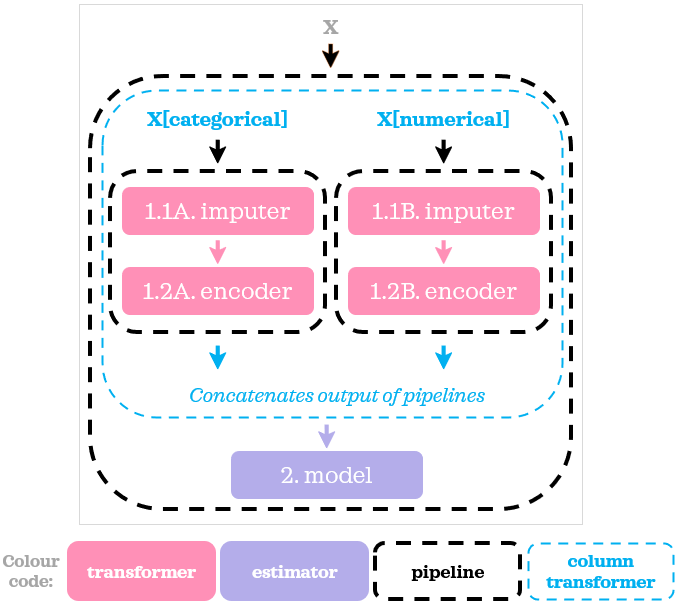

### 3. FeatureUnion

In [13]:
# Define custom transformer
class ColumnSelector(BaseEstimator, TransformerMixin):
    """Select only specified columns."""
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]

# Define categorical pipeline
cat_pipe = Pipeline([
    ('selector', ColumnSelector(categorical)),
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Define numerical pipeline
num_pipe = Pipeline([
    ('selector', ColumnSelector(numerical)),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

# Fit feature union to training data
preprocessor = FeatureUnion([
    ('cat', cat_pipe),
    ('num', num_pipe)
])
preprocessor.fit(X_train)

# Prepare column names
cat_columns = preprocessor.transformer_list[0][1][2].get_feature_names(categorical)
columns = np.append(cat_columns, numerical)

# Inspect training data before and after
print("******************** Training data ********************")
display(X_train)
display(pd.DataFrame(preprocessor.transform(X_train), columns=columns))

# Inspect test data before and after
print("******************** Test data ********************")
display(X_test)
display(pd.DataFrame(preprocessor.transform(X_test), columns=columns))

******************** Training data ********************


,smoker,day,time,size
169,Yes,Sat,Dinner,2.0
31,No,NaN,Dinner,NaN
112,No,Sun,Dinner,3.0
187,Yes,NaN,Dinner,NaN


,smoker_No,smoker_Yes,day_Sat,day_Sun,day_missing,time_Dinner,size
0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,1.0,1.0,0.5
2,1.0,0.0,0.0,1.0,0.0,1.0,1.0
3,0.0,1.0,0.0,0.0,1.0,1.0,0.5


******************** Test data ********************


,smoker,day,time,size
19,No,NaN,Dinner,NaN


,smoker_No,smoker_Yes,day_Sat,day_Sun,day_missing,time_Dinner,size
0,1.0,0.0,0.0,0.0,1.0,1.0,0.5


In [14]:
# Define categorical pipeline
cat_pipe = Pipeline([
    ('selector', ColumnSelector(categorical)),
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Define numerical pipeline
num_pipe = Pipeline([
    ('selector', ColumnSelector(numerical)),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

# Combine categorical and numerical pipeline
preprocessor = FeatureUnion([
    ('cat', cat_pipe),
    ('num', num_pipe)
])

# Combine categorical and numerical pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])
pipe.fit(X_train, y_train)

# Predict training data
y_train_pred = pipe.predict(X_train)
print(f"Predictions on training data: {y_train_pred}")

# Predict test data
y_test_pred = pipe.predict(X_test)
print(f"Predictions on test data: {y_test_pred}")

Predictions on training data: [10.63 18.35 38.07 30.46]
Predictions on test data: [18.35]
